# Практикум по стохастическому анализу. Часть №2

Выполнил \
Пилюшенок Артур \
студент 415 группы ВМК МГУ

In [2]:
import numpy as np                              # matrix calculations
from matplotlib import pyplot as plt            # plotting
from time import time                           # time of calculations

# empirical cumulative distribution function, distributions and quantiles
from scipy.stats import ecdf, norm, poisson, t, f, probplot, chi2

# for integral
from itertools import combinations_with_replacement
from scipy.special import factorial

In [3]:
def rand_expo(l, *args):
    '''
    Exponential distribution generator
    returns tensor with given shapes
    l - parameter, must be positive
    args consists of positive integer numbers (resulting dimensions)
    dimension error handling in np.random.rand
    '''
    if not l > 0:
        raise ValueError('Parameter of exponential distribution must be a positive float number.')
    return -np.log(np.random.rand(*args)) / l

In [4]:
def rand_norm(loc, scale, *args):
    '''
    Standard normal distribution generator, derivative of rand_expo
    returns tensor with given shapes
    shapes error handling in rand_expo
    '''
    omega = rand_expo(0.5, *args)
    alpha = 2 * np.pi * np.random.rand(*args)
    return loc + scale * np.sqrt(omega) * np.cos(alpha)

## Задание 7

### Условие
1. Методом случайного поиска найти минимальное значение функции $f$ на множестве $A = \{(x_1,x_2):~x_1^2+x_2^2\leqslant 1\}$, где
$$
f(x_1,x_2) = x_1^3\sin\frac{1}{x_1} + 10x_1x_2^4\cos\frac{1}{x_2},\quad x_1,x_2\neq0.
$$
При $x_1=0$ или $x_2=0$ функция доопределяется по непрерывности.

2. Методом имитации отжига найти минимальное значение функции Розенброка $g$ в пространстве $\mathbb{R}^2$, где
$$
g(x) = (x_1-1)^2 + 100(x_2-x_1^2)^2.
$$

3. Оценить точность и сравнить результаты со стандартными методами оптимизации.

### Метод случайного поиска

Метод случайного поиска минимального значения функции $f(x)$ на множестве $A$:
1. Смоделировать выборку размера $n$ точек $x\sim\mathrm{U}\{A\}$ (равномерно распределены на множестве A)
2. Выбрать ту реализацию случайной величины, на которой достигается наименьшее значение.

По условию задачи множество $A$ - круг единичного радиуса на плоскости $(x_1,x_2)$. Пусть $x=(x_1,x_2)\sim\mathrm{U}(A)$. По определению для любого борелевского множества $M$ выполняется ($\mu$ - мера Лебега на плоскости)
$$
\mathbb{P}\left( (x_1,x_2)\in M \right) = \dfrac{\mu (M)}{\mu (A)} = \dfrac{1}{\pi}\iint\limits_M dt_1dt_2 = \begin{vmatrix}
t_1 = r\cos\alpha \\
t_2 = r\sin\alpha
\end{vmatrix} = \dfrac{1}{\pi}\iint\limits_M rdrd\alpha = \iint\limits_M d(r^2)d\left(\frac{\alpha}{2\pi}\right).
$$

Следовательно, будем моделировать
$$
\begin{cases}
x_1 = \sqrt{\omega}\cos\alpha \\
x_2 = \sqrt{\omega}\sin\alpha
\end{cases}
$$
где $\omega\sim\mathrm{U}[0,1], \alpha\sim\mathrm{U}[0,2\pi]$.


Данная функция $f(x)=x_1^3\sin\frac{1}{x_1}+10x_1x_2^4\cos\frac{1}{x_2}$ обладает свойствами 
1. $f(x_1,-x_2)=f(x_1,x_2)$ (чётность по $x_2$)
2. $f(-x_1,0)=f(x_1,0)=x_1^3\sin\frac{1}{x_1}$
3. $f(0,0)=0$

Следовательно, если $x^*=(x_1^*,x_2^*)$ доставляет минимум функции, то $(x_1^*,-x_2^*)$ также доставляет минимум. \
Минимум меньше нуля, ведь $f(0.1, 0.1) < 0$ (проверяется численно). \
Следовательно, функция $f$ имеет хотя бы две точки глобального минимума.

Отметим, что при реализации метода случайного поиска значения $x_1=0, x_2=0$ достигаются с нулевой вероятностью. Следовательно, при вычислении значения заданной функции в точках выборки можно не обрабатывать неопределенность.

<!-- Пусть $\varepsilon>0$ - наперед заданная точность вычислений.  -->
Пусть $x^*=(x_1^*,x_2^*)$ доставляет минимум функции $f(x_1,x_2)$. \
Оценим точность работы алгоритма при помощи многомерной теоремы Лагранжа
$$
|f(x) - f(x^*)| \leqslant \max\limits_A 
\sqrt{\left(\dfrac{\partial f}{\partial x_1}\right)^2 + \left(\dfrac{\partial f}{\partial x_2}\right)^2} \cdot || x - x^* ||.
$$

Справедливы следующие оценки
$$
\begin{aligned}
\left|\dfrac{\partial f}{\partial x_1}\right| &= \left| 3x_1^2\sin\frac{1}{x_1} - x_1\cos\frac{1}{x_1} + 10x_2^4\cos\frac{1}{x_2}  \right| \leqslant 14. \\
\left|\dfrac{\partial f}{\partial x_2}\right| &= \left| 40x_1x_2^3\cos\frac{1}{x_2} + 10x_1x_2^2\sin\frac{1}{x_2} \right| \leqslant 50.
\end{aligned}
$$

Далее выберем окрестность радиуса $\delta\in(0,1)$: $B_\delta(x^*)=\{ x: ||x-x^*||\leqslant \delta \}$. \
Пусть $p$ - вероятность того, что в $B_\delta(x^*) \cap A$ находится хотя бы одна точка выборки $(x_1,x_2,\dots,x_n)$.
$$
p = \mathbb{P}(\exists k:~||x_k-x||\leqslant\delta) = 1 - \mathbb{P}(\forall k~ ||x_k-x^*||>\delta) = 1 - \prod_{k=1}^n\mathbb{P}(||x_k-x^*||>\delta).
$$

Если $B_\delta(x^*) \cap A = B_\delta(x^*)$, вероятность в правой части полученного выражения можно вычислить как отношение соответствующих площадей:
$$
\mathbb{P}(||x_k-x^*||>\delta) = \dfrac{\pi - \pi\delta^2}{\pi} = 1 - \delta^2 < 1 - \frac{\delta^2}{2}.
$$
Если $B_\delta(x^*) \cap A \neq B_\delta(x^*)$, то ограничим вероятность сверху числом $1-\frac{\delta^2}{2}$. Этот случай включает в себя возможное расположение точки $x^*$ на границе единичного круга. Ясно, что в худшем случае половина окрестности не будет лежать в круге.

Таким образом
$$
1-p = \prod_{k=1}^n\mathbb{P}(||x_k-x^*||>\delta) < \left(1-\frac{\delta^2}{2}\right)^n.
$$
Зафиксируем $p, \delta$. Тогда с вероятностью $p$ в окрестности радиуса $\delta$ искомого решения будет находиться элемент выборки, если размер выборки составляет
$$
n = \bigg\lfloor\dfrac{\ln(1-p)}{\ln\left(1-\frac{\delta^2}{2}\right)}\bigg\rfloor.
$$

Если выбрать $x\in B_\delta(x^*)$ погрешность вычисления составит
$$
|f(x) - f(x^*)| \leqslant \sqrt{14^2 + 50^2}\cdot\delta = \varepsilon.
$$
Таким образом, по заданным $\varepsilon$ - погрешности вычисления и $p$ - уровне доверия, можно вычислить $\delta, n$.

In [ ]:
def func(x1, x2):
    return x1 ** 3 * np.sin(1 / x1) + 10 * x1 * x2 ** 4 * np.cos(1 / x2)

def min_random_search(func, eps, p):
    delta = eps / np.sqrt(2696)
    n_points = np.floor(np.log(1 - p) / np.log(1 - delta**2 / 2)).astype(int)
    omega_sample = np.random.rand(n_points)
    alpha_sample = np.random.rand(n_points) * 2 * np.pi
    x1 = np.sqrt(omega_sample) * np.cos(alpha_sample)
    x2 = np.sqrt(omega_sample) * np.sin(alpha_sample)
    f_min = np.min(func(x1, x2))
    i_min = np.argmin(func(x1, x2))
    return f_min, [x1[i_min], x2[i_min]], n_points


print(f"f(0.1,0.1) = {func(0.1,0.1):.4f} < 0.")

eps = 0.05
p = 0.99
val, point, n_points = min_random_search(func, eps, p)
print(f"f*({point[0]:.8f},{point[1]:.8f})= {val:.8f} obtained by sample of {n_points} points.")

f(0.1,0.1) = -0.0006 < 0
f*(-0.36138661,0.93240933)= -1.28821618 obtained by sample of 9932428 points.


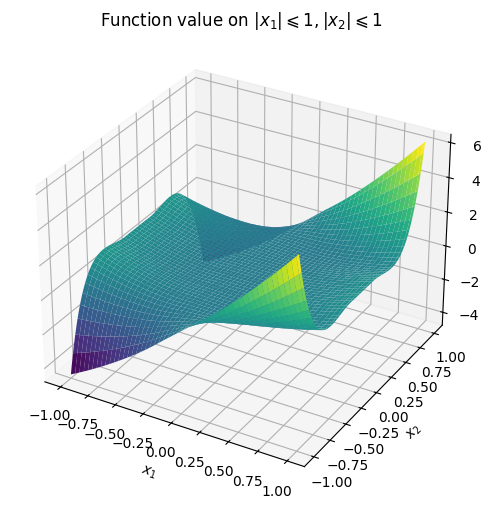

In [12]:
n_points = 100
grid = np.linspace(-1, 1, n_points, endpoint=True)
X1, X2 = np.meshgrid(grid, grid)

plt.figure(figsize=(9,6))
ax = plt.axes(projection='3d')
ax.plot_surface(X1, X2, func(X1, X2), cmap='viridis')
ax.set_title('Function value on $|x_1|\leqslant1, |x_2|\leqslant1$')
ax.set_xlabel('$x_1$')
ax.set_ylabel('$x_2$')
plt.show()

### Метод имитации отжига

In [7]:
def func_g(x):
    return (x[0] - 1)**2 + 100 * (x[1] - x[0]**2)**2

def choose_neighbour(s_i, T_i):
    sigma = 0.25
    return rand_norm(s_i, sigma * np.sqrt(T_i))

def transfer_probability(d_F_i, T_i):
    return np.exp(-d_F_i * T_i)

def reduce_temperature(T_i):
    k = 0.79
    return k * T_i

T = 0.01

s_i = [1, 1]
T_i = T
func_last = 0
iter_count = 1000

for i in range(iter_count):
    func_value = func_g(s_i)
    transfer = transfer_probability(func_value - func_last, T_i)
    neighbour = choose_neighbour(s_i, T_i)
    if np.random.rand() < transfer:
        s_i = choose_neighbour(s_i, T_i)
    T_i = reduce_temperature(T_i)
    func_last = func_value

func_last

np.float64(0.041102588788348174)

### Сравнение методов

## Задание 8

### Условие
1. Применить метод Монте-Карло к решению первой краевой задачи для двумерного уравнения Лапласа в единичном круге
$$
\begin{cases}
\Delta u = 0,(x,y)\in D \\
u\vert_{\delta D} = f(x,y) \\
u\in C^2(D), f\in C(\delta D) \\
D=\{(x,y)\in\mathbb{R}^2: x^2+y^2\leqslant 1 \}
\end{cases}
$$

2. Для функции $f(x,y) = x^2-y^2$ найти аналитическое решение и сравнить с полученным по методу Монте-Карло.

In [ ]:
import itertools

def solve_Laplace(func, n_points, n_tests):

    def find_nearest():
        

    carthesian_grid = list(itertools.product(np.linspace(-1, 1, n_points), repeat=2))


n_points = 10 + 1
step = 
carthesian_grid = list(itertools.product(np.linspace(-1, 1, n_points), repeat=2))

for point in test:
    x, y = point
    if (abs(x) == 1 or abs(y) == 1):
        continue
    

array(<itertools.product object at 0x000001D2D785BAC0>, dtype=object)

## Задание 9

### Условие

Рассмотреть два вида гауссовских процессов:

- Винеровский процесс $W(t), t\in[0,1], W(0)=0$

- Процесс Орнштейна-Уленбека $X(t), t\in[0,1], X(0)=X_0$, т.е. стационарный марковский гауссовский процесс. Начальные значения $X_0$ следует выбирать случайным образом так, чтобы полученный процесс был стационарным.

Для данных процессов:

1. Найти ковариационную функцию и переходные вероятности.

2. Промоделировать независимые траектории процесса с данными переходными вероятностями методом добавления разбиения отрезка.

3. Построить график траектории, не соединяя точки ломаной, с целью получения визуально непрерывной линии.

## Задание 10

### Условие

Произвести фильтрацию одномерного процесса Орнштейна-Уленбека:

1. Используя генетор белого шума, добавить к реализации процесса Орнштейна-Уленбека случайную ошибку с заранее известной дисперсией.

2. При помощи одномерного фильтра Калмана оценить траекторию процесса по зашумленному сигналу, считая известными параметры шума и процесса.

3. Рассмотреть следующие виды шума:
    1. Гауссов
    2. Коши (шум имеет распределение Коши)

## Задание 11

### Условие

Построить двумерное пуассоновское поле, отвечающее сложному пуассоновскому процессу:

1. Система массового обслуживания. Первая координата поля - время поступления заявки в СМО (распределение равномерно), а вторая - время обслуживания заявки (распределение $\chi^2$ с десятью степенями свободы).

2. Система массового обслуживания с циклической интенсивностью $\lambda(1+\cos(t))$ и единичными скачками. При помощи метода Льюиса и Шедлеара, свести задачу моделирования неоднородного пуассоновского процесса к моделированию двумерного пуассоновского поля, где первая координата распределена равномерно, а вторая имеет распределение Бернулли.

3. Работа страховой компании: первая координата - момент наступления страхового случая (равномерное распределение), вторая величина ущерба (распределение Парето). Поступление капитала считать линейным по времени со скоростью $c>0$, начальный капитал $W>0$.